In [0]:
!rm -r Projeto-Inteligencia-Artificial
!git clone https://github.com/Crissky/Projeto-Inteligencia-Artificial.git

rm: cannot remove 'Projeto-Inteligencia-Artificial': No such file or directory
Cloning into 'Projeto-Inteligencia-Artificial'...
remote: Enumerating objects: 16851, done.
remote: Total 16851 (delta 0), reused 0 (delta 0), pack-reused 16851
Receiving objects: 100% (16851/16851), 1.95 GiB | 44.34 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Checking out files: 100% (19473/19473), done.


In [0]:
%tensorflow_version 1.x
#Imports
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
#from keras.layers.merge import concatenate
#from keras.layers import Input
from keras import backend as K
 
#from pyimagesearch.simplenet import SimpleNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
#from keras.preprocessing.image import ImageDataGenerator
#from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import cv2
import os

import matplotlib
matplotlib.use("Agg")

Using TensorFlow backend.


In [0]:
#Modelo
def plants_build(width, height, depth, classes, reg):
  model = Sequential()
  inputShape = (height, width, depth)

  # if we are using "channels first", update the input shape
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)

  model.add(Conv2D(256, (11, 11), input_shape=inputShape, padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(Conv2D(128, (5, 5), padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (5, 5), padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(Dropout(0.12))

  model.add(Dense(classes))
  model.add(Activation("softmax"))
    
  return model

In [0]:
#Dataset
def loadDataSet(arg_dataset, myDepth):
  print("Path", arg_dataset)
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(arg_dataset))
  data = []
  labels = []
  
  for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]

    image = cv2.imread(imagePath)
    if(myDepth == 1):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    data.append(image)
    labels.append(label)

  num_classes = len(list(set(labels)))

  data = np.array(data, dtype="float") / 255.0
  data = data.reshape((data.shape[0], data.shape[1], data.shape[2], myDepth))
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(labels)
  labels = np_utils.to_categorical(labels, num_classes)

  (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.40, stratify=labels, random_state=42)
  return (trainX, testX, trainY, testY, label_encoder)

In [0]:
#Training
def createModel(mWidth, mHeight, myDepth, label_encoder, arg_epochs, opt=None):
	print("[INFO] compiling model...")
	if(not opt):
		#opt = SGD(lr=1e-4, momentum=0.9)
		opt = Adam(lr=1e-4, decay=1e-4 / arg_epochs)
 
	model = plants_build(width=mWidth, height=mHeight, depth=myDepth,
		classes=len(label_encoder.classes_), reg=l2(0.0002))
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])

	try:
		#model.load_weights("Projeto-Inteligencia-Artificial/weights/weights_rgb.h5")
		print("[INFO] Weights loaded\n")
	except Exception as ex:
		print("[FAIL] Weights not loaded\n", ex)
 
	return model

def traningModel(model, trainX, trainY, testX, testY, label_encoder, arg_epochs, myBatch_size=32):
	print("[INFO] training network for {} epochs...".format(
		arg_epochs))

	H = model.fit(trainX, trainY,
				validation_data=(testX, testY), batch_size=myBatch_size,
				epochs=arg_epochs, verbose=1)

	print("[INFO] evaluating network...")
	predictions = model.predict(testX, batch_size=myBatch_size)
	print(classification_report(testY.argmax(axis=1),
		predictions.argmax(axis=1), target_names=label_encoder.classes_))

	return (model, H)

In [0]:
#Atributos
mWidth=200#200
mHeight=267#150
myDepth = 3
myBatch_size = 32
arg_epochs = 80

In [0]:
arg_dataset = "Projeto-Inteligencia-Artificial/imagens{}x{}".format(mWidth,mHeight)
(trainX, testX, trainY, testY, label_encoder) = loadDataSet(arg_dataset, myDepth)
model = createModel(mWidth, mHeight, myDepth, label_encoder, arg_epochs)
(model1, H1) = traningModel(model, trainX, trainY, testX, testY, label_encoder, arg_epochs, myBatch_size)

Path Projeto-Inteligencia-Artificial/imagens200x267
[INFO] loading images...
[INFO] compiling model...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] Weights loaded

[INFO] training network for 80 epochs...



Train on 137 samples, validate on 92 samples
Epoch 1/80





137/137 [==============================] - 36s 264ms/step - loss: 0.9611 - acc: 0.5693 - val_loss: 0.9514 - val_acc: 0.4891
Epoch 2/80
137/137 [==============================] - 6s 46ms/step - loss: 0.9618 - acc: 0.5547 - val_loss: 0.9461 - val_acc: 0.6957
Epoch 3/80
137/137 [==============================] - 6s 46ms/step - loss: 0.9504 - acc: 0.5255 - val_loss: 0.9429 - val_acc: 0.5435
Epoch 4/80
137/137 [==============================] - 6s 46ms/step - loss: 0.9510 - acc: 0.5109 - val_loss: 0.9430 - val_acc: 0.5435
Epoch 5/80
137/137 [==========

In [0]:
arg_dataset = "Projeto-Inteligencia-Artificial/imagens_masked{}x{}".format(mWidth,mHeight)
(trainX, testX, trainY, testY, label_encoder) = loadDataSet(arg_dataset, myDepth)
model = createModel(mWidth, mHeight, myDepth, label_encoder, arg_epochs)
(model2, H2) = traningModel(model, trainX, trainY, testX, testY, label_encoder, arg_epochs, myBatch_size)

Path Projeto-Inteligencia-Artificial/imagens_masked200x267
[INFO] loading images...
[INFO] compiling model...
[INFO] Weights loaded

[INFO] training network for 80 epochs...
Train on 137 samples, validate on 92 samples
Epoch 1/80
137/137 [==============================] - 8s 55ms/step - loss: 0.9996 - acc: 0.5109 - val_loss: 0.9465 - val_acc: 0.6739
Epoch 2/80
137/137 [==============================] - 7s 49ms/step - loss: 0.9400 - acc: 0.5182 - val_loss: 0.9361 - val_acc: 0.6413
Epoch 3/80
137/137 [==============================] - 7s 49ms/step - loss: 0.9213 - acc: 0.6569 - val_loss: 0.9098 - val_acc: 0.7391
Epoch 4/80
137/137 [==============================] - 7s 49ms/step - loss: 0.8355 - acc: 0.6788 - val_loss: 0.8666 - val_acc: 0.7065
Epoch 5/80
137/137 [==============================] - 7s 49ms/step - loss: 0.7984 - acc: 0.7372 - val_loss: 0.8334 - val_acc: 0.7500
Epoch 6/80
137/137 [==============================] - 7s 49ms/step - loss: 0.7065 - acc: 0.7883 - val_loss: 0.8186 -

In [0]:
arg_dataset = "Projeto-Inteligencia-Artificial/imagens_augmented{}x{}".format(mWidth,mHeight)
(trainX, testX, trainY, testY, label_encoder) = loadDataSet(arg_dataset, myDepth)
model = createModel(mWidth, mHeight, myDepth, label_encoder, arg_epochs)
(model3, H3) = traningModel(model, trainX, trainY, testX, testY, label_encoder, arg_epochs, myBatch_size)

Path Projeto-Inteligencia-Artificial/imagens_augmented200x267
[INFO] loading images...
[INFO] compiling model...
[INFO] Weights loaded

[INFO] training network for 80 epochs...
Train on 824 samples, validate on 550 samples
Epoch 1/80
824/824 [==============================] - 52s 63ms/step - loss: 0.9673 - acc: 0.5170 - val_loss: 0.9361 - val_acc: 0.4764
Epoch 2/80
824/824 [==============================] - 38s 47ms/step - loss: 0.9307 - acc: 0.5255 - val_loss: 0.9219 - val_acc: 0.5527
Epoch 3/80
824/824 [==============================] - 39s 47ms/step - loss: 0.9065 - acc: 0.5595 - val_loss: 0.9043 - val_acc: 0.4873
Epoch 4/80
824/824 [==============================] - 39s 47ms/step - loss: 0.8549 - acc: 0.6153 - val_loss: 0.8473 - val_acc: 0.5727
Epoch 5/80
824/824 [==============================] - 38s 47ms/step - loss: 0.7806 - acc: 0.6966 - val_loss: 0.7935 - val_acc: 0.7600
Epoch 6/80
824/824 [==============================] - 38s 47ms/step - loss: 0.6475 - acc: 0.7998 - val_loss

In [0]:
arg_dataset = "Projeto-Inteligencia-Artificial/imagens_masked_augmented{}x{}".format(mWidth,mHeight)
(trainX, testX, trainY, testY, label_encoder) = loadDataSet(arg_dataset, myDepth)
model = createModel(mWidth, mHeight, myDepth, label_encoder, arg_epochs)
(model4, H4) = traningModel(model, trainX, trainY, testX, testY, label_encoder, arg_epochs, myBatch_size)

Path Projeto-Inteligencia-Artificial/imagens_masked_augmented200x267
[INFO] loading images...
[INFO] compiling model...
[INFO] Weights loaded

[INFO] training network for 80 epochs...
Train on 824 samples, validate on 550 samples
Epoch 1/80
824/824 [==============================] - 42s 51ms/step - loss: 0.9472 - acc: 0.5388 - val_loss: 0.9247 - val_acc: 0.5673
Epoch 2/80
824/824 [==============================] - 40s 49ms/step - loss: 0.8916 - acc: 0.6493 - val_loss: 0.9150 - val_acc: 0.4855
Epoch 3/80
824/824 [==============================] - 40s 49ms/step - loss: 0.8200 - acc: 0.7233 - val_loss: 0.7907 - val_acc: 0.6618
Epoch 4/80
824/824 [==============================] - 40s 49ms/step - loss: 0.6082 - acc: 0.8447 - val_loss: 0.7081 - val_acc: 0.7218
Epoch 5/80
824/824 [==============================] - 40s 49ms/step - loss: 0.4762 - acc: 0.8993 - val_loss: 0.6846 - val_acc: 0.7600
Epoch 6/80
824/824 [==============================] - 40s 49ms/step - loss: 0.3971 - acc: 0.9308 - v

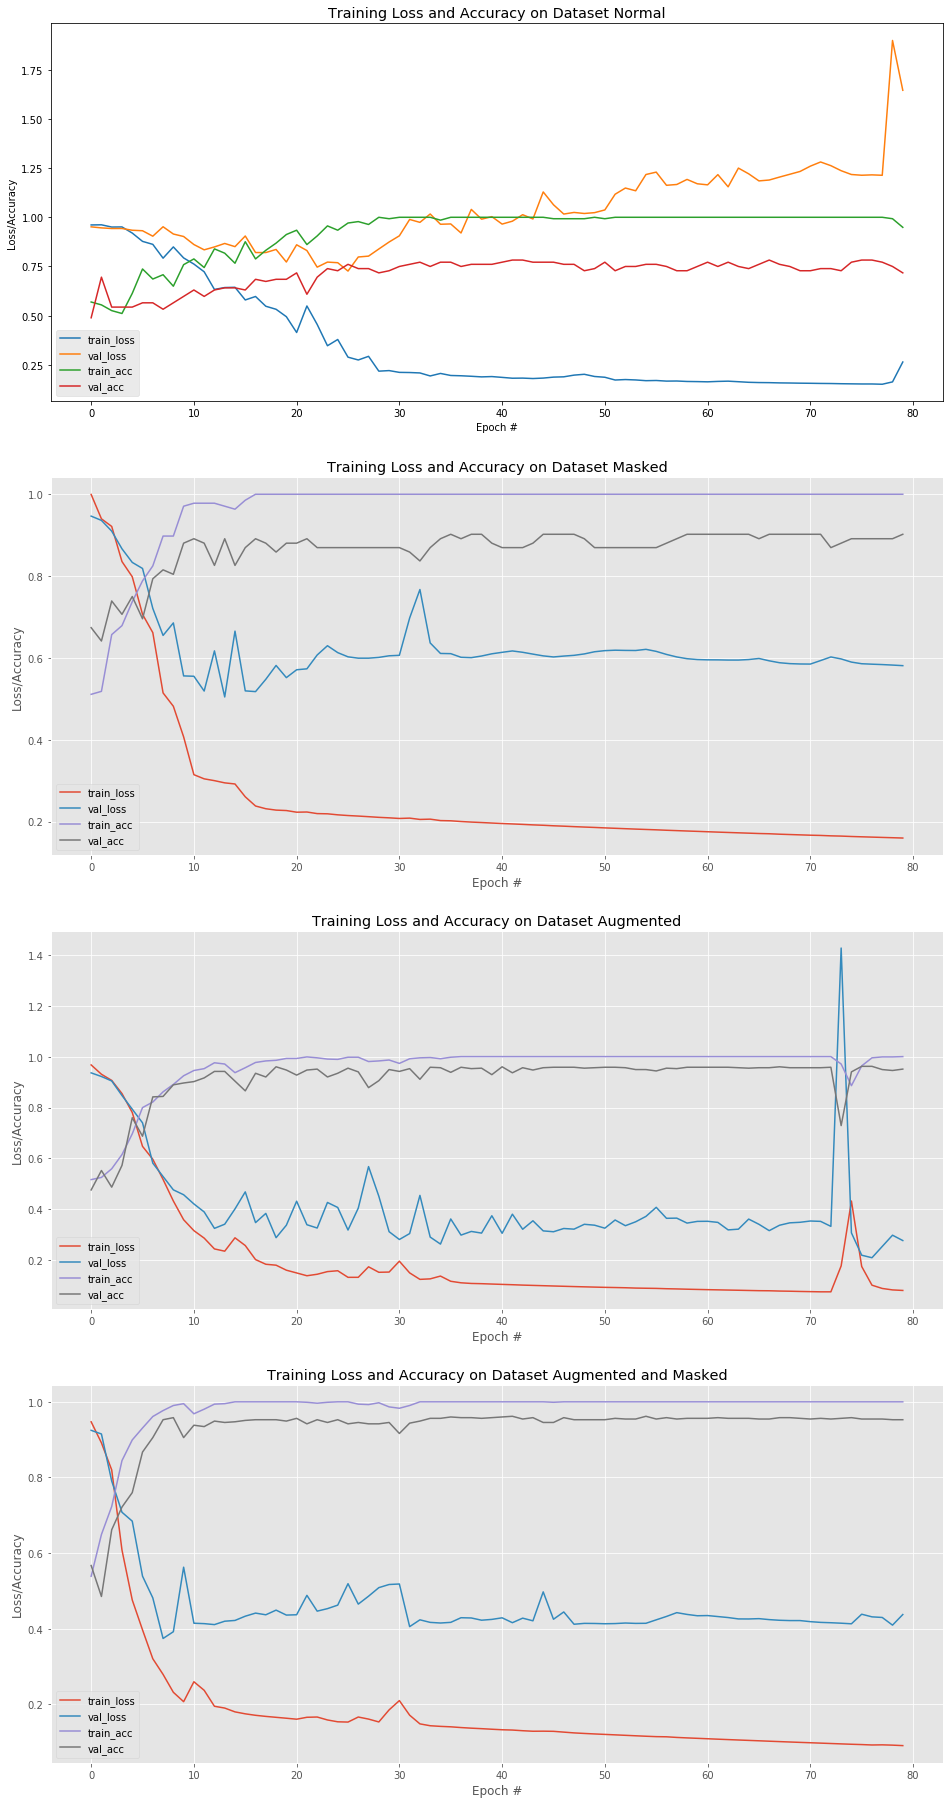

In [0]:
#Results
%matplotlib inline
N = arg_epochs
models = [(model1, H1), (model2, H2), (model3, H3), (model4, H4)]
model_names = ["Normal", "Masked", "Augmented", "Augmented and Masked"]
plt.rcParams["figure.figsize"] = (16,32)

for index in range(len(models)):
  plt.subplot(len(models), 1, (index+1))
  plt.style.use("ggplot")
  plt.plot(np.arange(0, N), models[index][1].history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), models[index][1].history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), models[index][1].history["acc"], label="train_acc")
  plt.plot(np.arange(0, N), models[index][1].history["val_acc"], label="val_acc")
  plt.title("Training Loss and Accuracy on Dataset {}".format(model_names[index]))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")

plt.show()

In [0]:
#model.save_weights("Pesos.h5")

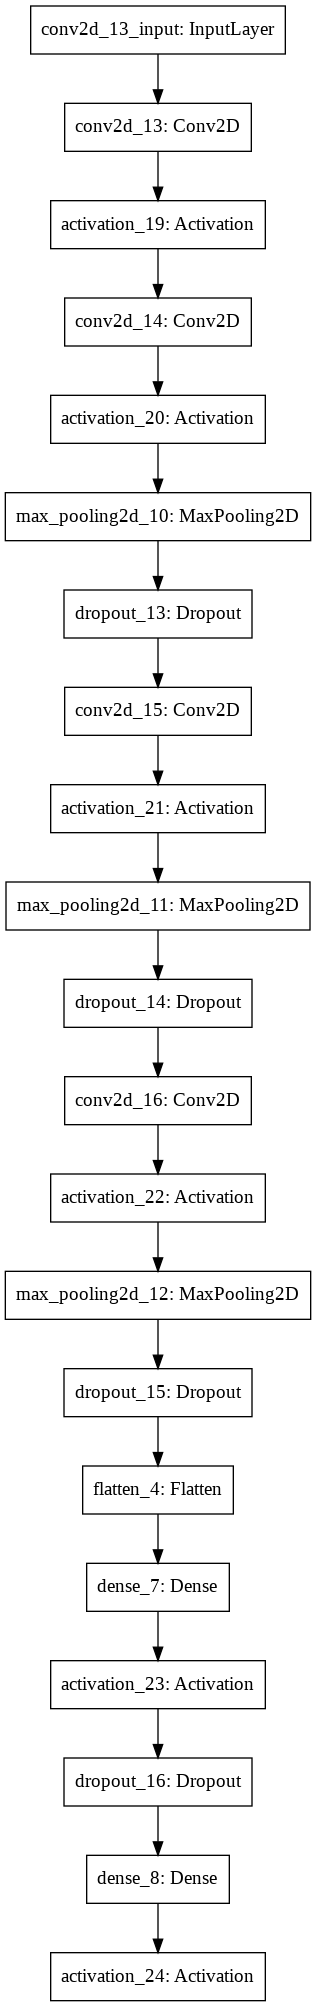

In [0]:
#Gera imagem do modelo da rede 

from keras.utils import plot_model
plot_model(model, to_file='model.png')